# Tutorial: Preprocessing and Vectorize the data

> __In this tutorial, we will:__
> 1. Preprocessing the data (randomly collections of 10000 tweets from twitter) and analyze name entity, noun and noun phrases used in those tweets
> 2. Transform all tweets to vectors by 3 method:
>  - Bag of Words
>  - TF-IDF
>  - Vector attribute from spacy
> 3. Use K-Nearest Neighbors to index those vectors; get a random tweet and show the k neighbors and combare the results of 3 methods

### What do we need ?
- Import all general library we need for this task. 3 news library that we need to notice:
 - Spacy: a free open-source library for Natural Language Processing in Python.
 - Regression (re): help us clean data by replacing special characters and words
 - Counter: Do Statistical Analysis on Name Entity, Noun and Noun Phrase

In [1]:
import pandas as pd
import numpy as np
import string
#Regression Library 
import re
import spacy
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
#Load Englisg language from Spacy library
nlp = spacy.load('en')

#### 1. Preproccssing raw dataa and analyze some features
- Get the raw data from csv file

In [2]:
#Get the raw data from file
main_file_path = 'tweet_dataset.csv'
data = pd.read_csv(main_file_path)

- 3 function we need to implement to for preprocessing:
 - is_alpha() : eleminate all characters which art not alphabet word
 - clean_text(): Transform all numbers to label NUM and all emails to label EMAIL, remove @user, link, \r and \n
 - tokenize(): Tokenize all words of tweets (Only get alphabet word except some words) 

In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

remove_words = ["what", "who", "why", "when", "where", "a", "an", "the", "that", "this", "those", "there", "just", "yet", "please"]
special = ["NUM", "EMAIL"]

def is_alpha(word):
    try:
        return word.encode('ascii').isalpha()
    except:
        return False

def clean_text(txt):
    ###Use RE to:
    #Replace an email by EMAIL
    txt = ' '.join(re.sub("[A-Za-z0-9]+@[A-Za-z]+.[A-Za-z]","EMAIL",txt).split())
    #Replace number by NUM
    txt = ' '.join(re.sub(" [0-9]+ ","NUM",txt).split())
    #Remove tweets' link, @user 
    txt = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",txt).split())
    #Remove \r \n
    txt = ' '.join(re.sub("\r|\n"," ",txt).split())
    return txt

#Use Spacy to tokenize
def tokenize(sent):
    tweet = nlp(sent)
    lemmas = []
    for i in range(len(tweet)):
        #tweet_b = nlp(sent)
        if tweet[i].text in special:
            lemmas.append('@'+tweet[i].text.lower())
            name_entity.append('@'+tweet[i].text.lower())
        else:
            if tweet[i].text.lower() not in remove_words and is_alpha(tweet[i].text):
                lemmas.append(tweet[i].lemma_.lower().strip() if tweet[i].lemma_ != "-PRON-" else tweet[i].lower_)
                #Extract Name Entities
                if tweet[i].ent_type != 0:
                    name_entity.append(tweet[i].text.lower())
                #Extract Noun
                if tweet[i].pos_ == "NOUN":
                    noun.append(tweet[i].lemma_.lower().strip())
                #
                #if tweet[i].pos_ == "NOUN":
                #    pos = tweet_b[i].left_edge.i
                #    span = tweet_b[tweet_b[i].left_edge.i : tweet_b[i].right_edge.i+1]
                #    span.merge()
                #    print (span)
                #    if tweet_b[pos].dep_ in np_labels:
                #        noun_phrase.append(tweet_b[pos].text.lower())
    lemmas = ' '.join(lemmas)
    return lemmas

> ___Note:___ Process of extracting name entities, nouns and noun phrases runs after between cleaning text and tokenizing. After tokenizing, because of removing some special words, we will have some problems in extraction those feature.

- In function tokenize(), we also implement 2 if conditions to extract Name Entities and Nouns from all tweets.
 - Token.ent_type returns the type of a name entity. If the return values is not equal to 0, extract that token
 - Token.pos_ returns the part-of-speech of a token. If it returns "NOUN", extract that token
- Because the process of noun phrase extract is more complicated, we have to implement get_noun_phrase()

In [4]:
np_labels = ["nsubj", "nsubjpass", "dobj", "iobj", "pobj", "attr"]
#Extract Noun phrase
def get_noun_phrase(sent):
    tweet = nlp(sent)
    i = 0
    while True:
        if tweet[i].text not in special:
            if not tweet[i].is_stop and tweet[i].text.lower() not in STOP_WORDS and is_alpha(tweet[i].text):
                #Find a noun in a sentence (because a noun phrase will contains at least a noun)
                if tweet[i].pos_ == "NOUN":
                    #Calculate the position of merged token in tweet after merging
                    pos = tweet[i].left_edge.i
                    #Calculate the position of the next token in tweet after merging
                    new_pos = tweet[i].left_edge.i + 1
                    #Get syntactic descendant of token and merge them as a new token
                    span = tweet[tweet[i].left_edge.i : tweet[i].right_edge.i+1]
                    span.merge()
                    #Only get merged token whose depth attribute is in np_labels
                    if tweet[pos].dep_ in np_labels:
                        noun_phrase.append(tweet[pos].text.lower())
                    i = new_pos - 1
        if i + 1 == len(tweet):
            break
        else:
            i += 1

- After implement all neccessary process, runs them
- Firstly, cleaning text

In [5]:
tweets = data['Content']
for i in range(len(tweets)):
    tweets[i] = clean_text(tweets[i])
#ps = pd.Series(tweets)
#ps.to_csv('Clean_tweet.csv')

- Then extracting 3 features and tokenize the data

In [6]:
name_entity = []
noun = []
noun_phrase = []

#This data is used for method 3
tokenized_data = []
#This data is used for method 1 & 2
tokenized_data_strings = []
for i in range(len(tweets)):
    #Extract noun phrases
    get_noun_phrase(tweets[i])
    #Get tokenized data
    string = tokenize(tweets[i])
    tokenized_data.append(nlp(string))
    tokenized_data_strings.append(string)
    if (i % 500 == 0):
        print (i)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


- After extracting name entities, nouns and noun phrases, we use Counter to count, analyze and plot the 20 most common of them

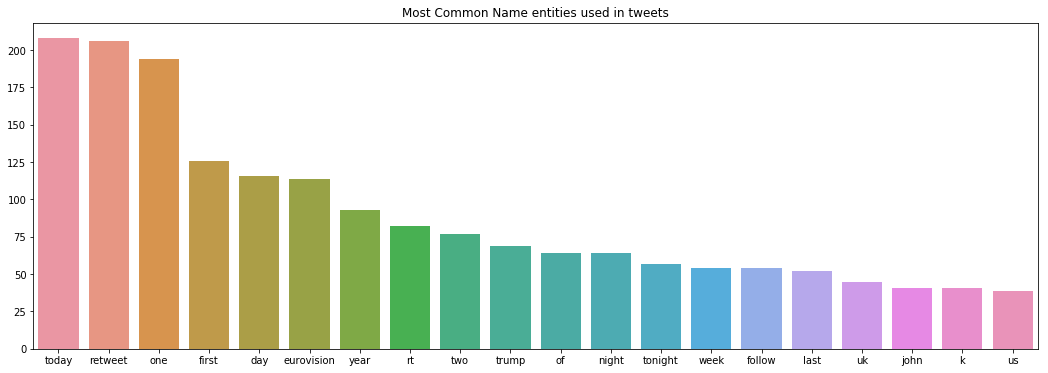

In [7]:
#Plot 20 most common name entities used in tweets
name_entity_count = Counter(name_entity)

common_words = [word[0] for word in name_entity_count.most_common(20)]
common_counts = [word[1] for word in name_entity_count.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=common_words, y=common_counts)
plt.title('Most Common Name entities used in tweets')
plt.show()

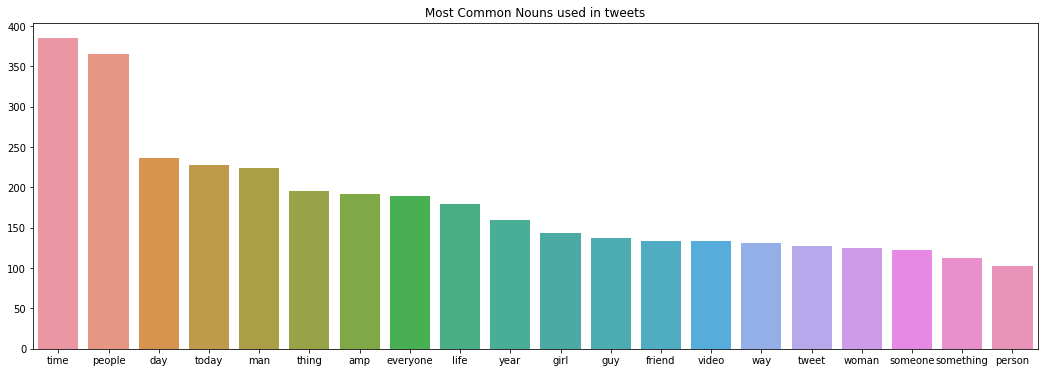

In [8]:
#Plot 20 most common nouns used in tweets
noun_count = Counter(noun)

common_nouns = [word[0] for word in noun_count.most_common(20)]
common_ncounts = [word[1] for word in noun_count.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=common_nouns, y=common_ncounts)
plt.title('Most Common Nouns used in tweets')
plt.show()

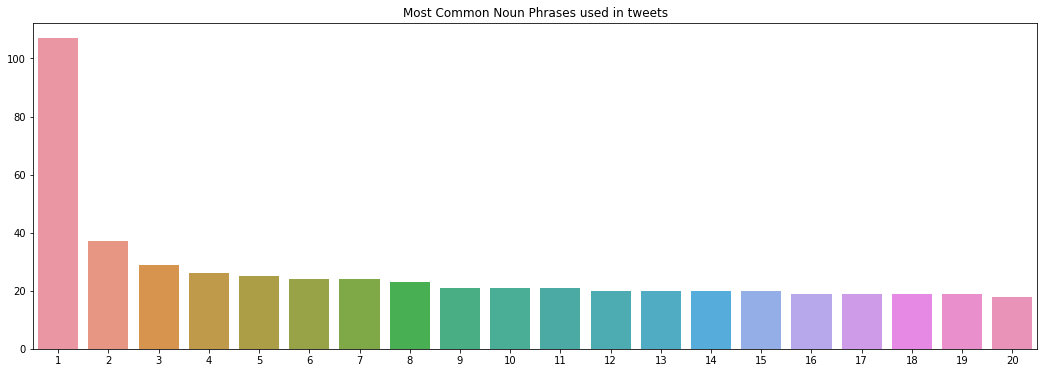

1 people
2 life
3 that thang
4 love
5 today
6 things
7 the world
8 a video
9 the coolest thing
10 the happiest place on earth 💫
11 t
12 u
13 my mom
14 an arguement with your man
15 army = best of me
16 m
17 this guy
18 your recent efforts
19 capricorn
20 work


In [9]:
#Plot 20 most common noun phrases used in tweets
noun_phrase_count = Counter(noun_phrase)

common_noun_phrase = [word[0] for word in noun_phrase_count.most_common(20)]
common_npcounts = [word[1] for word in noun_phrase_count.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=list(range(1, 21)), y=common_npcounts)
plt.title('Most Common Noun Phrases used in tweets')
plt.show()

for i in range(len(common_noun_phrase)):
    print (i + 1, common_noun_phrase[i])
    

#### 2. Transform to vector
- In this part, we will use 3 methods:
 

1/ Bag of Words: Create a dictionary of words, the number of word in this dictionary will be the dimension of vector. The value of the dimensions of a sentence's vector will be calculate by the occurance of the dimension word. Use __CountVectorizer Library__ to get vectorizer and transform

In [10]:
#Method 1: Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_BoW = CountVectorizer(stop_words='english')
X1 = vectorizer_BoW.fit_transform(tokenized_data_strings)
vectors_m1 = X1.toarray()
print (vectors_m1.shape)

(10000, 13424)


2/ TF-IDF: The ideas is the same with BoW.However, after get the vector by counting, we have to calculate the value again to make the vector more accuracy (The occurance of popular words will make the result wrong. TF-IDF will help us solve this problem.  Use __TfidfVectorizer Library__ to get vectorizer and transform

In [8]:
 #Method 2: Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

X2 = vectorizer_tfidf.fit_transform(tokenized_data_strings)
vectors_m2 = X2.toarray()
print (vectors_m2.shape)

(10000, 13424)


3/ Sentence Vector attribute: Spacy provides us an attribute to transfer a sentence to a vector. This attribute will return the mean vector of all words'vector in that sentence

In [9]:
#Method 3: Sentence Vectorn
zero = np.full(384, 0)
vectors_m3 = np.empty([len(tokenized_data), len(tokenized_data[0].vector)])
for i in range(len(tokenized_data)):
    if tokenized_data[i].vector.shape == (0,):
        vectors_m3[i] = zero
    else:
        vectors_m3[i] = tokenized_data[i].vector
        
print (vectors_m3.shape)

(10000, 384)


#### 3. Indexing vectors by K-Nearest Neighbors and test by a random tweet
- Use knn to fit all 3 vector lists of 3 methods.
- Get a random tweet. Find the k nearest neighbor (k = 10) and compare result between 3 methods

___Note:___ I will get a random tweet from 10000 tweets, which means the element of knn is always itself

In [13]:
from random import randint
ran_tweet_i = randint(0, len(vectors_m1) - 1)

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=10) #get model knn where k = 10

#Use kkn for vectors of method 1
neigh.fit(vectors_m1)
knn_list_m1 = neigh.kneighbors([vectors_m1[ran_tweet_i]], return_distance = False)
print (knn_list_m1)

#Use kkn for vectors of method 2
neigh.fit(vectors_m2)
knn_list_m2 = neigh.kneighbors([vectors_m2[ran_tweet_i]], return_distance = False)
print (knn_list_m2)

#Use kkn for vectors of method 3
neigh.fit(vectors_m3)
knn_list_m3 = neigh.kneighbors([vectors_m3[ran_tweet_i]], return_distance = False)
print (knn_list_m3)

print (tokenized_data_strings[ran_tweet_i])
for i in range(1, 10):
    print (i)
    print (tokenized_data_strings[knn_list_m1[0][i]])
    print (tokenized_data_strings[knn_list_m2[0][i]])
    print (tokenized_data_strings[knn_list_m3[0][i]])

[[5234 9688 3398 7953 6153 5117 6065 7412 5511 5213]]
[[5234 5707 5700 5545 5562 5511 5455 5069 5420 5213]]
[[5234 4088 6268 5014 7798 7713 3553 4218 9012  624]]
at time be in hargeisa be do my research paper and we shall meet if possible mr president
1
time
and you still be go nowhere
do i have to be bear in new orleans now my food expectation high asf like nothing else compare to our food
2
should be but it take time
you
my mom have pass on ryan mom be in arizona anneli will be with chris amp his family they get back together amp
3
me next time
i do same
if i could spend my summer vacation in place like long island in it have my family friend job and do
4
time be
you still have do it
dear do you see these statement by your new attorney on time warner merger be they true as yo
5
it time
both
my wife and baby be do well with right treatment her condition should be threat to either of them s
6
have time part

nawaz sharif have prove time and time again he be indian lacky time for him to